# NX-421 Mini-Project 1 — Part 1 (Steps 3–6)

In [1]:
import os, os.path as op

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn import plotting, image
from nilearn.datasets import fetch_atlas_aal, load_mni152_template
from nilearn import plotting
from nilearn.image import get_data
from scipy.ndimage import label
import os.path as op
from nilearn.image import threshold_img, math_img
from nilearn.maskers import NiftiLabelsMasker

PREPROC_DATA_ROOT = op.abspath('derivatives/preprocessed_data')
BASE_DATA_ROOT = op.abspath('data')
OUTPUT_DIR = op.abspath('glm_results')
os.makedirs(OUTPUT_DIR, exist_ok=True)

FUNC_IMG = op.join(PREPROC_DATA_ROOT, 'concatenated_rescaled_moco.nii.gz')

EVENT_FILES = [op.join(BASE_DATA_ROOT, 'fMRI', 'tFMRI_MOTOR_LR', 'events_LR.csv'),
               op.join(BASE_DATA_ROOT, 'fMRI', 'tFMRI_MOTOR_RL', 'events_RL.csv')]

## Load functional image and TR
We read the preprocessed concatenated 4D BOLD and extract TR from header.


In [2]:
fmri_img = nib.load(FUNC_IMG)
TR = fmri_img.header.get_zooms()[-1]
n_scans = fmri_img.shape[-1]
print(f'Loaded {FUNC_IMG}')
print(f'TR = {TR}s, n_scans = {n_scans}')

Loaded /data/derivatives/preprocessed_data/concatenated_rescaled_moco.nii.gz
TR = 0.7200000286102295s, n_scans = 568


## Load events


In [3]:
def load_events(paths):
    """Load event files and prepare for concatenation."""
    events = []
    for idx, path in enumerate(paths):
        if not op.isfile(path):
            raise FileNotFoundError(f'Events file not found: {path}')
        df = pd.read_csv(path)
        required = ['onset', 'duration', 'condition']
        missing = [col for col in required if col not in df.columns]
        if missing:
            raise ValueError(f'Missing columns {missing} in {path}')
        df = df[required].copy()
        df.rename(columns={'condition': 'trial_type'}, inplace=True)
        df['run_idx'] = idx
        events.append(df)
    return events

def adjust_events(events_list, run_scans, tr):
    """Adjust event onsets for concatenated runs."""
    if len(events_list) == 1:
        # Only one run, no adjustment needed
        df = events_list[0].drop(columns=['run_idx'])
        return df.reset_index(drop=True)
    
    if len(run_scans) != len(events_list):
        raise ValueError(f'Run lengths ({len(run_scans)}) do not match number of event files ({len(events_list)})')
    
    # Calculate time offset for each run
    offsets = np.cumsum([0.0] + [scans * tr for scans in run_scans[:-1]])
    
    # Apply offsets to each run's events
    adjusted = []
    for df, offset in zip(events_list, offsets):
        tmp = df.copy()
        tmp['onset'] = tmp['onset'] + offset
        adjusted.append(tmp)
    
    # Combine all runs
    out = pd.concat(adjusted, ignore_index=True)
    return out.drop(columns=['run_idx']).reset_index(drop=True)

RUN_SCANS = [284, 284]
event_tables = load_events(EVENT_FILES)

# Adjust event timing for concatenated runs
events = adjust_events(event_tables, RUN_SCANS, TR)

# Remove rows with NaN
n_total_before = len(events)
events = events.dropna(subset=['trial_type']).reset_index(drop=True)
n_removed = n_total_before - len(events)

if n_removed > 0:
    print(f'!!! Removed {n_removed} event(s) with missing trial_type')

print(f'Total valid events: {len(events)}')
unique_types = sorted(events['trial_type'].unique())
print(f'Unique trial types ({len(unique_types)}): {unique_types}')
events.head()

!!! Removed 2 event(s) with missing trial_type
Total valid events: 46
Unique trial types (7): ['cue', 'fixation', 'lf', 'lh', 'rf', 'rh', 't']


,onset,duration,trial_type
0,8.0,3.0,cue
1,11.0,12.0,rh
2,23.0,3.0,cue
3,26.0,12.0,lf
4,38.0,3.0,cue


## 3. Design matrix


Design matrix shape: (568, 16)
Columns: ['cue', 'fixation', 'lf', 'lh', 'rf', 'rh', 't', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'constant']


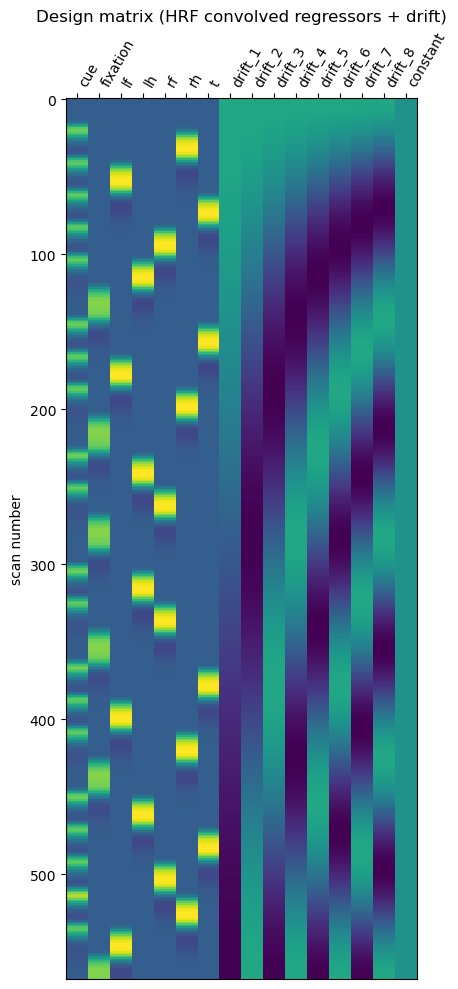

,cue,fixation,lf,lh,rf,rh,t,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,drift_7,drift_8,constant
0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059339,0.059338,0.059337,0.059335,0.059333,0.059331,0.059328,0.059325,1.0
0.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059337,0.059331,0.059321,0.059306,0.059288,0.059266,0.059239,0.059208,1.0
1.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059333,0.059316,0.059288,0.059248,0.059197,0.059135,0.059061,0.058976,1.0
2.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059328,0.059295,0.059239,0.059161,0.059061,0.058939,0.058795,0.058629,1.0
2.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.059321,0.059266,0.059174,0.059045,0.058880,0.058679,0.058441,0.058167,1.0


In [4]:
from nilearn.plotting import plot_design_matrix

frame_times = np.arange(n_scans) * TR
design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events,
    hrf_model='spm',
    drift_model='cosine',
    high_pass=0.01
)

print(f'Design matrix shape: {design_matrix.shape}')
print(f'Columns: {list(design_matrix.columns)}')

# Visualize and save design matrix
ax = plot_design_matrix(design_matrix)
ax.set_title('Design matrix (HRF convolved regressors + drift)')
plt.tight_layout()
plt.savefig(op.join(OUTPUT_DIR, 'design_matrix.png'), dpi=150)
plt.show()

design_matrix.head()

## 4. GLM


In [10]:

# Parameters

z_threshold = 3.1
min_cluster_size = 150
fixed_slices = [-10, 0, 20, 40]
vmax = 6.5
vmin = -6.5
bg_img = load_mni152_template()


# GLM setup & fit

fmri_glm = FirstLevelModel(
    t_r=float(TR),
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model='cosine',
    high_pass=0.01
)

print('Fitting GLM...')
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=[design_matrix])
print('GLM fitting complete!')


# Identify task regressors

task_cols = [c for c in design_matrix.columns if c not in ('constant',) and not c.startswith('drift_')]

# Cluster-thresholding function

def cluster_threshold(zmap_nii, z_thresh=z_threshold, min_size=min_cluster_size):
    data = zmap_nii.get_fdata().copy()

    # Positive clusters
    mask_pos = data > z_thresh
    labeled_pos, n_pos = label(mask_pos)
    for i in range(1, n_pos + 1):
        if np.sum(labeled_pos == i) < min_size:
            data[labeled_pos == i] = 0

    # Negative clusters
    mask_neg = data < -z_thresh
    labeled_neg, n_neg = label(mask_neg)
    for i in range(1, n_neg + 1):
        if np.sum(labeled_neg == i) < min_size:
            data[labeled_neg == i] = 0

    return nib.Nifti1Image(data, zmap_nii.affine, zmap_nii.header)


#Compute, cluster, and plot z-map

for col in task_cols:
    print(f'Processing task: {col}')
    
    # Compute z-map
    zmap = fmri_glm.compute_contrast(col, output_type='z_score')
    
    # Apply cluster threshold
    zmap_clusters = cluster_threshold(zmap)
    
    # Plot clusters with consistent slices & color scale
    display = plotting.plot_stat_map(
        zmap_clusters,
        bg_img=bg_img,
        threshold=z_threshold,
        display_mode='z',
        cut_coords=fixed_slices,
        title=f'Clustered Z-map: {col}',
        colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cmap='cold_hot'
    )
    

    out_png = op.join(OUTPUT_DIR, f'zmap_{col}_clusters.png')
    display.savefig(out_png, dpi=150)
    display.close()

print("All cluster-only GLM z-map PNGs saved.")


Fitting GLM...
GLM fitting complete!
Processing task: cue
Processing task: fixation
Processing task: lf
Processing task: lh
Processing task: rf
Processing task: rh
Processing task: t
All cluster-only GLM z-map PNGs saved.


## 5. Hand vs. Foot contrast
We define a contrast averaging left/right hands vs. left/right feet.


In [11]:
# Based on HCP motor task: lh, rh (hands) vs. lf, rf (feet)
hand_cols = ['lh', 'rh']
foot_cols = ['lf', 'rf']

# Create contrast vector: Hand > Foot assigning to  each condition equal weight, normalized within group
contrast_vector = np.zeros(len(design_matrix.columns))
for i, col in enumerate(design_matrix.columns):
    if col in hand_cols:
        contrast_vector[i] = 1.0 / len(hand_cols)
    elif col in foot_cols:
        contrast_vector[i] = -1.0 / len(foot_cols)

# Show contrast weights
print('Contrast weights:')
for i, col in enumerate(design_matrix.columns):
    if contrast_vector[i] != 0:
        print(f'  {col}: {contrast_vector[i]:+.4f}')

# Compute contrast
hand_vs_foot_z = fmri_glm.compute_contrast(contrast_vector, output_type='z_score')

# Save contrast map
contrast_nii = op.join(OUTPUT_DIR, 'zmap_hand_vs_foot.nii.gz')
hand_vs_foot_z.to_filename(contrast_nii)

# Visualize
display = plotting.plot_stat_map(
    hand_vs_foot_z, bg_img=load_mni152_template(), 
    threshold=3.1, display_mode='z', cut_coords=7,
    title='Hand > Foot (Z > 3.1)'
)
display.savefig(op.join(OUTPUT_DIR, 'zmap_hand_vs_foot.png'), dpi=150)
display.close()

Contrast weights:
  lf: -0.5000
  lh: +0.5000
  rf: -0.5000
  rh: +0.5000


## 6. Overlay Contrast Map with the AAL Atlas Parcellation


In [15]:

# Parameters for clustering
z_threshold = 3.1
min_cluster_size = 50

# Function to keep only clusters above threshold and minimum size
def cluster_threshold(zmap_nii, z_thresh=z_threshold, min_size=min_cluster_size):
    data = zmap_nii.get_fdata().copy()

    # Positive clusters
    mask_pos = data > z_thresh
    labeled_pos, n_pos = label(mask_pos)
    for i in range(1, n_pos + 1):
        if np.sum(labeled_pos == i) < min_size:
            data[labeled_pos == i] = 0

    # Negative clusters
    mask_neg = data < -z_thresh
    labeled_neg, n_neg = label(mask_neg)
    for i in range(1, n_neg + 1):
        if np.sum(labeled_neg == i) < min_size:
            data[labeled_neg == i] = 0

    return nib.Nifti1Image(data, zmap_nii.affine, zmap_nii.header)


hand_vs_foot_clusters = cluster_threshold(hand_vs_foot_z)


aal = fetch_atlas_aal()
atlas_img = nib.load(aal['maps']) if isinstance(aal['maps'], str) else aal['maps']
labels = list(aal['labels'])
print(f'AAL atlas loaded with: {len(labels)} regions')

atlas_res = image.resample_to_img(atlas_img, fmri_img, interpolation='nearest')

# Compute region-wise mean z-value using clustered z-map
masker = NiftiLabelsMasker(labels_img=atlas_res, standardize=False)
reg_vals = masker.fit_transform(hand_vs_foot_clusters)
reg_vals = reg_vals.ravel()

# Create DataFrame and sort by z-value
region_df = pd.DataFrame({'label': labels, 'mean_z': reg_vals})
region_df_sorted = region_df.sort_values('mean_z', ascending=False)

csv_path = op.join(OUTPUT_DIR, 'regions_hand_vs_foot_AAL.csv')
region_df_sorted.to_csv(csv_path, index=False)
print(f'\nSaved region analysis to: {csv_path}')

# Display top regions
print('\nTOP 10 REGIONS: Hand > Foot (highest positive z-values)')
for idx, row in region_df_sorted.head(10).iterrows():
    print(f'- {row["label"]:20s} | z = {row["mean_z"]:+.3f}')

print('\nTOP 10 REGIONS: Foot > Hand (most negative z-values)')
for idx, row in region_df_sorted.tail(10).iloc[::-1].iterrows():
    print(f'- {row["label"]:20s} | z = {row["mean_z"]:+.3f}')

# --- Visualization: contrast map with AAL overlay (clusters only) ---
disp = plotting.plot_stat_map(
    hand_vs_foot_clusters, 
    bg_img=load_mni152_template(), 
    threshold=z_threshold, 
    display_mode='z', 
    cut_coords=7,
    title='Hand > Foot (Clustered Z-map) with AAL overlay'
)
disp.add_overlay(atlas_res, cmap='tab20', alpha=0.15)
disp.savefig(op.join(OUTPUT_DIR, 'zmap_hand_vs_foot_clusters_with_AAL.png'), dpi=150)
disp.close()


AAL atlas loaded with: 116 regions

Saved region analysis to: /data/glm_results/regions_hand_vs_foot_AAL.csv

TOP 10 REGIONS: Hand > Foot (highest positive z-values)
- Precentral_R         | z = +0.858
- Frontal_Inf_Orb_L    | z = +0.751
- Temporal_Pole_Mid_L  | z = +0.704
- Cingulum_Post_R      | z = +0.696
- Insula_L             | z = +0.689
- Frontal_Inf_Tri_L    | z = +0.538
- Postcentral_R        | z = +0.535
- Temporal_Pole_Sup_L  | z = +0.493
- Supp_Motor_Area_R    | z = +0.471
- Olfactory_R          | z = +0.428

TOP 10 REGIONS: Foot > Hand (most negative z-values)
- Cerebelum_3_R        | z = -1.238
- SupraMarginal_R      | z = -1.079
- Cerebelum_3_L        | z = -1.033
- Vermis_8             | z = -0.990
- Paracentral_Lobule_L | z = -0.930
- Insula_R             | z = -0.867
- Heschl_R             | z = -0.803
- Angular_R            | z = -0.798
- Vermis_7             | z = -0.758
- Putamen_R            | z = -0.743
